# **Tomato Disease Classification**
The project deals with the classification of tomato diseases on the basis of photos of leaves. Deep machine learning techniques were used for the solution, and the process of creating the appropriate model was described step by step along with short theoretical notes.

Dataset credits: [Kaggle](https://www.kaggle.com/datasets/arjuntejaswi/plant-village)

#### Importing all libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import models, layers
plt.style.use('seaborn')

## **Data collection**
We start working on the problem with data collection.

### Importing data
So firsly, we need to import the data. For this purpose will use *image_dataset_from_directory* api to load all images in tensorflow dataset. Fortunately, the analyzed data is stored in an appropriate structure, because images representing tomato leaves were separated based on the disease and saved in appropriate directiories. 

In [2]:
# Dataset parameters
batch_size = 32      
image_size = 256

# Creating dataset object
ds = tf.keras.preprocessing.image_dataset_from_directory(
    'tomatoes',
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size)

print(ds)

Found 16011 files belonging to 10 classes.
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


As we see below *image_dataset_from_directory* automaticaly extract names of classes from the folders names. 

In [3]:
# Defining classes names
class_names = ds.class_names
class_names

['Bacterial_spot',
 'Curl_Virus',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria',
 'Spider_mites',
 'Target_Spot']

In [17]:
n_classes = len(class_names)

Tensorflow automaticaly extract names of classes from the folders names. Now we can move to vizualizing the data.

### Visualization of sample data from the data set
Few images of leaves with coreesponding classes from one batch are presented below.

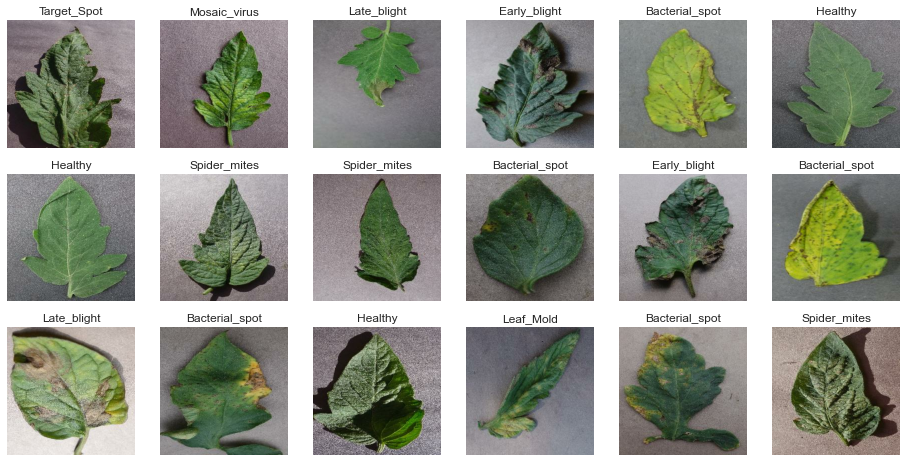

In [4]:
plt.figure(figsize=(16, 8))
for image, label in ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

### Distribution of class sizes
We will check the number of images of leaves representing a given class to check whether we are dealing with a balanced or unbalanced data set.

In [5]:
labels = np.array([])
for _, label in ds.take(len(ds)): 
    labels = np.concatenate((labels, label.numpy()), axis=0)
labels = [class_names[int(label)] for label in labels]

In [6]:
labels_counter = dict(Counter(labels))
labels_counter

{'Target_Spot': 1404,
 'Curl_Virus': 3208,
 'Septoria': 1771,
 'Late_blight': 1909,
 'Healthy': 1591,
 'Mosaic_virus': 373,
 'Leaf_Mold': 952,
 'Spider_mites': 1676,
 'Bacterial_spot': 2127,
 'Early_blight': 1000}

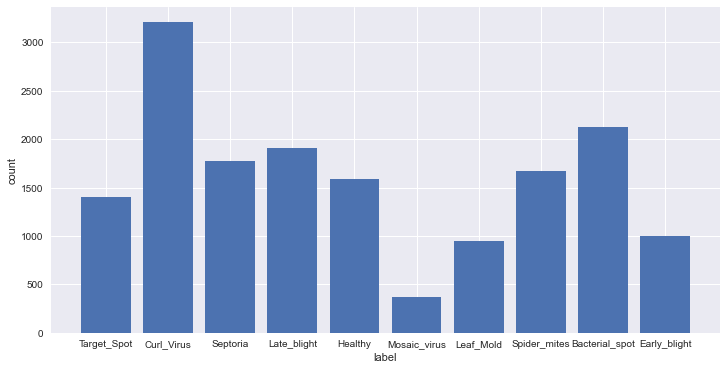

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xlabel('label'); plt.ylabel('count')
plt.show()

### Dataset spliting
Dataset should be bifurcated into 3 subsets, namely:
- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [8]:
train_size = 0.75
val_size = 0.10
test_size = 0.15

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.1, test_split=0.15, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=40)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

### Dataset caching, shuffling and prefetching
Before building a model, it's good to autotune our dataset. It is recommended by tensorflow to prefetch our Dataset class, because it will optimize calculation by doing them in parallel. Moreover, if we want the order of the elements in the sets to be random, we have to shuffle them.

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building a model

### Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [15]:
data_augumentation = tf.keras.Sequential([
    # Random flipping
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    # Random rotation
    layers.experimental.preprocessing.RandomRotation(0.2),
    # Random zooming
    layers.experimental.preprocessing.RandomZoom(0.15)
])

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. 

In [18]:
input_shape = (batch_size, image_size, image_size, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

### Compiling the Model
We use adam Optimizer, Sparse Categorical Crossentropy for losses, accuracy as a metric

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
375/375 [==============================] - 400s 1s/step - loss: 1.6334 - accuracy: 0.4199 - val_loss: 1.5299 - val_accuracy: 0.5138
Epoch 2/50
375/375 [==============================] - 363s 967ms/step - loss: 1.0546 - accuracy: 0.6356 - val_loss: 1.0901 - val_accuracy: 0.6550
Epoch 3/50
375/375 [==============================] - 365s 974ms/step - loss: 0.7890 - accuracy: 0.7292 - val_loss: 1.8915 - val_accuracy: 0.5387
Epoch 4/50
375/375 [==============================] - 352s 938ms/step - loss: 0.6217 - accuracy: 0.7857 - val_loss: 1.0276 - val_accuracy: 0.6637
Epoch 5/50
375/375 [==============================] - 349s 930ms/step - loss: 0.5217 - accuracy: 0.8169 - val_loss: 0.7620 - val_accuracy: 0.7444
Epoch 6/50
375/375 [==============================] - 349s 930ms/step - loss: 0.4655 - accuracy: 0.8361 - val_loss: 0.7602 - val_accuracy: 0.7450
Epoch 7/50
375/375 [==============================] - 345s 919ms/step - loss: 0.3887 - accuracy: 0.8669 - val_loss: 0.9758 - va

Scores of our model is:

In [23]:
scores = model.evaluate(test_ds)

76/76 [==============================] - 30s 187ms/step - loss: 0.2470 - accuracy: 0.9289


We can see above that we get 92.89% accuracy for our test dataset. This is considered to be a pretty good accuracy.

### Plotting the accuracy and loss curves

Text(0.5, 1.0, 'Training and Validation Loss')

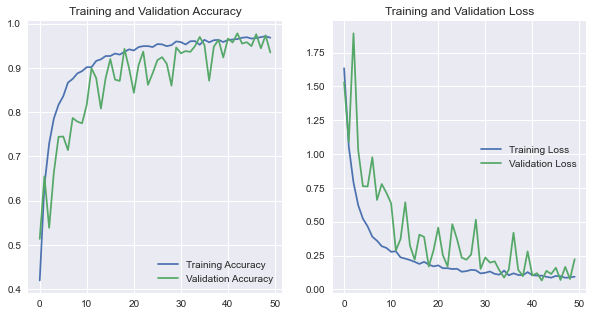

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='right')
plt.title('Training and Validation Loss')

### Run prediction on few sample images

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

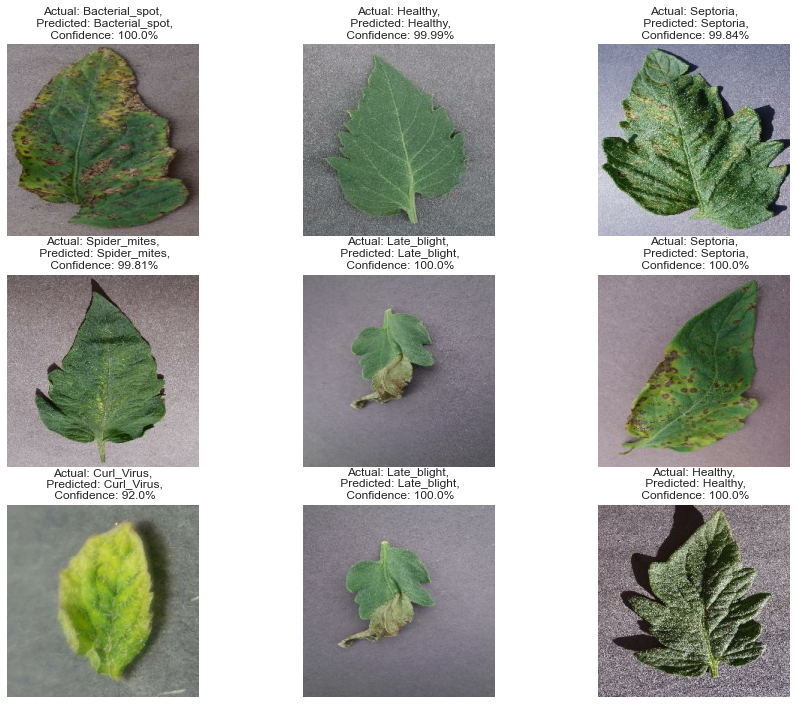

In [30]:
plt.figure(figsize=(15, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence =  predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%')
        
        plt.axis('off')

### Saving the Model

In [33]:
model_version = 1
model.save(f'./saved_models/{model_version}')

INFO:tensorflow:Assets written to: ./saved_models/1\assets
